In [1]:
from pymongo import MongoClient
import gensim 
import pandas as pd  
import numpy as np 


client = MongoClient('localhost', 27017)
db = client['TweetFULLTorini']

tweets = pd.DataFrame(list(db['FinalCLEAN'].find()))

data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['text']
data['Id'] = tweets['_id']
data['len']  = np.array([len(tweet) for tweet in data['Tweets']])
user = list()
for i in range(0,len(tweets)):
    user.append(tweets['user'][i]['name'])
data['user'] = np.array(user)

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from utils import tokenize_and_stem

docs = data['Tweets']

myStopWords=set(stopwords.words('italian')
                +stopwords.words('english')+
                list(['http','abbiat', 'abov', 'anch', 'avess', 'avest', 'avet', 'avev', 'avrebb',
                      'avrest', 'avret', 'avut', 'becaus', 'befor', 'could', 'doe', 'dure', 'ebb',
                      'erav', 'facciat', 'facess', 'facest', 'facev', 'farebb', 'farest', 'faret',
                      'foss', 'fost', 'might', 'must', 'need', 'nostr', 'onc', 'onli', 'ourselv',
                      'qual', 'quant', 'quell', 'quest', 'sarebb', 'sarest', 'saret', 'siat',
                      'siet', 'starebb', 'starest', 'staret', 'stavat', 'stess', 'stest', 'stett',
                      'stiat', 'themselv', 'thi', 'veri', 'vostr', 'would', 'yourselv','becau','http']))

tagged_data = [TaggedDocument(words=tokenize_and_stem(_d,stopwords=myStopWords), tags=[str(i)]) for i, _d in enumerate(docs)]

In [112]:
model = Doc2Vec(vector_size=100, dbow_words= 1, dm=0,  window=5, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(tagged_data)
for epoch in range(10):
    print("epoch "+str(epoch))
    model.train(tagged_data, total_examples=len(tagged_data), epochs=1)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [113]:
X = model[model.wv.vocab]

In [114]:
#HDBSCAN

In [115]:
import hdbscan

hdbs=hdbscan.HDBSCAN(min_cluster_size=20,min_samples=1, cluster_selection_method='leaf')
hdbs.fit_predict(X)

array([-1, -1, -1, ..., -1, -1, -1])

Counter({4: 364, 3: 94, 0: 47, 2: 38, 1: 27, 5: 20})


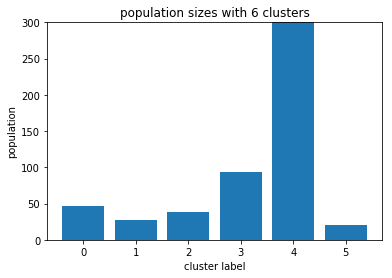

In [116]:
from sklearn.metrics import silhouette_score
import collections
import matplotlib.pyplot as plt

labels = list(hdbs.labels_)

labels = [x for x in labels if x != -1]

plt.bar(range(len(set(labels))), np.bincount(labels))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(len(set(labels))));

# truncate y axis to see the rest better
plt.ylim(0,300);

print (collections.Counter(labels))

In [117]:
def get_nwords(cluster, n):
    
    prob=hdbs.probabilities_#tutte prob

    labels_index = [i for i, x in enumerate(labels) if x == cluster]#indice label cluster
        
    cluster_vectors= [X[x] for x in labels_index]#vettori cluster

    cluster_probabilities = [prob[x] for x in labels_index]#probabilità cluster
    
    words={}
    
    for t in range(0,n-1):
        largest_prob = max(cluster_probabilities)
        largest_prob_index = cluster_probabilities.index(largest_prob)
        cluster_probabilities.remove(largest_prob)
        word=model.wv.index2entity[largest_prob_index]
        words[word]=largest_prob
        
    return words
    

    
def describe_clusters(clusterer,num_words):
    
    labels = list(hdbs.labels_)
    labels = [x for x in labels if x != -1]
    
    num_clusters = len(set(labels))
    
    for n in range(0, num_clusters):
        
        print('Cluster',n,': ',get_nwords(n,num_words))

In [118]:
describe_clusters(hdbs,4)

Cluster 0 :  {'live': 0.7226364201180713, 'http': 0.0}
Cluster 1 :  {'tvdellosport': 0.6885636590774512, 'http': 0.0}
Cluster 2 :  {'http': 0.0}
Cluster 3 :  {'anno': 0.8598135614105533, 'roma': 0.7731226596271259, 'ieri': 0.7263845911848682}
Cluster 4 :  {'ingegneria': 1.0, 'stadio': 1.0}
Cluster 5 :  {'http': 0.0}
